# Downloading data

In [1]:
import torch
import yfinance as yf

# Other files
import utils
from models.autowarp import AutoWarp
from models.mean_variance_optimisation import MeanVarianceOptimisation
from models.autoencoders import LinearAutoencoder, ConvAutoencoder, ConvLinearAutoEncoder, train_autoencoder
from models.fama_french import FamaFrench

# General imports
import matplotlib.pyplot as plt
import matplotlib.ticker as tick
import numpy as np
import pandas as pd
import warnings
import json
from datetime import datetime
from datetime import timedelta
from dateutil.relativedelta import relativedelta


# Optimisation
from pypfopt.expected_returns import mean_historical_return
from pypfopt.hierarchical_portfolio import HRPOpt

# Set seed for reproducibility
torch.manual_seed(0)
np.random.seed(0);

In [2]:
# 2 years training (split into 2 year train and 1 year valid), 18 months test
start_date = '2017-03-01'
valid_date = '2019-03-01'
train_date = '2020-03-01'
end_date   = '2021-09-01'

prices_train, _, _, prices_test = utils.split_prices(start_date=start_date, valid_date=valid_date, train_date=train_date, end_date=end_date, train_valid_split=2/3)
data_train, _ = utils.split_orbis_data(start_date=start_date, valid_date=valid_date, train_date=train_date, returns=True, momentum=True, train_valid_split=2/3)

# Open json file with parameters
with open(f'params/sp500_{start_date}.json') as f:
    params = json.load(f)

num_epochs=20

In [3]:
# S&P 500
sp500 = yf.download("^GSPC", start=train_date, end=end_date, period="1d")['Adj Close']
sp500 = sp500.div(sp500.iloc[0]).mul(100)

[*********************100%***********************]  1 of 1 completed


# Calculating autoencoder distance matrix

In [4]:
models = {}
models['Linear'] = train_autoencoder(LinearAutoencoder, input_size=data_train.shape[1], num_epochs=num_epochs, data=data_train, verbose=True, **params['Linear']['sharpe']['autoencoder'])
models['CNN'] = train_autoencoder(ConvAutoencoder, input_size=data_train.shape[1], num_epochs=num_epochs, data=data_train, verbose=True, **params['CNN']['sharpe']['autoencoder'])
models['Linear + CNN'] =train_autoencoder(ConvLinearAutoEncoder, input_size=data_train.shape[1], num_epochs=num_epochs, data=data_train, verbose=True, **params['Linear + CNN']['sharpe']['autoencoder'])

LinearAutoencoder
Epoch [1/20], Loss: 0.0776
Epoch [2/20], Loss: 0.0228
Epoch [3/20], Loss: 0.0186
Epoch [4/20], Loss: 0.0164
Epoch [5/20], Loss: 0.0152
Epoch [6/20], Loss: 0.0144
Epoch [7/20], Loss: 0.0138
Epoch [8/20], Loss: 0.0131
Epoch [9/20], Loss: 0.0122
Epoch [10/20], Loss: 0.0114
Epoch [11/20], Loss: 0.0108
Epoch [12/20], Loss: 0.0101
Epoch [13/20], Loss: 0.0096
Epoch [14/20], Loss: 0.0091
Epoch [15/20], Loss: 0.0087
Epoch [16/20], Loss: 0.0083
Epoch [17/20], Loss: 0.0081
Epoch [18/20], Loss: 0.0080
Epoch [19/20], Loss: 0.0077
Epoch [20/20], Loss: 0.0076
ConvAutoencoder
Epoch [1/20], Loss: 0.1391
Epoch [2/20], Loss: 0.0777
Epoch [3/20], Loss: 0.0649
Epoch [4/20], Loss: 0.0589
Epoch [5/20], Loss: 0.0488
Epoch [6/20], Loss: 0.0393
Epoch [7/20], Loss: 0.0304
Epoch [8/20], Loss: 0.0261
Epoch [9/20], Loss: 0.0221
Epoch [10/20], Loss: 0.0191
Epoch [11/20], Loss: 0.0177
Epoch [12/20], Loss: 0.0166
Epoch [13/20], Loss: 0.0158
Epoch [14/20], Loss: 0.0152
Epoch [15/20], Loss: 0.0148
Epoc

In [5]:
%%time
dist_matrices = {}
for model in ['Linear', 'Linear + CNN', 'CNN']:
    print(model)
    learner = AutoWarp(models[model], data_train, **params[model]['sharpe']['dist_matrix'])
    learner.learn_metric(verbose=True)
    dist_matrices[model] = learner.create_distance_matrix()

Linear
Alpha: 0.5200504064559937
Gamma: 0.3741384744644165
Epsilon: 0.08481073379516602
Linear + CNN
Alpha: 0.45596927404403687
Gamma: 0.6408059597015381
Epsilon: 0.13956034183502197
CNN
Alpha: 0.42371606826782227
Gamma: 0.5314480662345886
Epsilon: 0.8417166471481323
CPU times: total: 1min 47s
Wall time: 25.7 s


# Mean variance optimisation

In [6]:
# Empty dict for weights
weights = {}

for model in ["Linear", "CNN", "Linear + CNN"]:

    # Setup
    e_returns = mean_historical_return(prices_train)
    optimiser = MeanVarianceOptimisation(expected_returns = e_returns, prices = prices_train, solver='OSQP', weight_bounds = (0,1))

    # Get weights
    risk_matrix = optimiser.make_risk_matrix(dist_matrices[model], **params[model]['sharpe']['risk_matrix'])
    weights[model], train_sr = optimiser.max_sharpe_ratio(risk_matrix=risk_matrix, l2_reg=0)

    # Print out summary
    print(model, train_sr)

for model in ["Covariance", "Covariance Shrinkage", "EW Covariance"]:

    # Setup
    e_returns = mean_historical_return(prices_train)
    optimiser = MeanVarianceOptimisation(expected_returns = e_returns, prices = prices_train, solver='OSQP', weight_bounds = (0,1))

    # Get weights
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        risk_matrix = optimiser.benchmark_matrix(model)
        weights[model], train_sr = optimiser.max_sharpe_ratio(risk_matrix=risk_matrix, l2_reg=0)

    # Print out summary
    print(model, train_sr)

# Factor model
e_returns = mean_historical_return(prices_train)
optimiser = MeanVarianceOptimisation(expected_returns = e_returns, prices = prices_train, solver='OSQP', weight_bounds = (0,1))
fama_french = FamaFrench(prices_train, file_path='data/F-F_Research_Data_Factors_daily.CSV', n_rows=25419)
fama_cov = fama_french.get_covariance_matrix()
weights['Fama-French 3 factor'], train_sr = optimiser.max_sharpe_ratio(risk_matrix=fama_cov, l2_reg=0)
print("Fama-French 3 factor", train_sr)

# HRP
rets = (prices_train/prices_train.shift(1)-1).dropna()
hrp = HRPOpt(rets)
hrp.optimize()
weights['HRP'] = pd.DataFrame.from_dict(hrp.clean_weights(), orient='index', columns=['weights'])
train_sr = utils.calculate_sharpe_ratio(prices = prices_test, weights = weights['HRP'])
print("HRP", train_sr)

# Equal weights
weights['Equal'] = weights['Linear'].copy()
weights['Equal']['weights'] = 1/weights['Linear']['weights'].shape[0]
print("Equal", utils.calculate_sharpe_ratio(weights=weights['Equal'], prices=prices_train))

Linear 0.6091214501447325
CNN 1.662433878687475
Linear + CNN 0.6204073972677089
Covariance 1.939973965165214
Covariance Shrinkage 1.937300576232849
EW Covariance 1.705576274971072


C:\Users\roryc\miniconda3\envs\metric_learning_env\lib\site-packages\cvxpy\problems\problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Fama-French 3 factor 1.628847242001857
HRP 0.9248594098138821
Equal 0.6760715227668997


# Evaulating performance on the test set

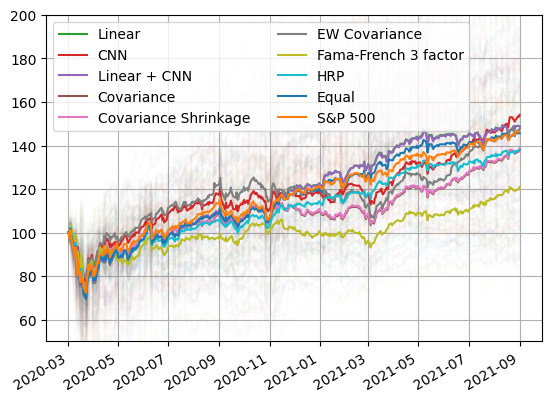

In [7]:
# Plots
plt.plot(prices_test, alpha=0.025)
for model in ["Linear", "CNN", "Linear + CNN", "Covariance", "Covariance Shrinkage", "EW Covariance", "Fama-French 3 factor", "HRP", "Equal"]:
    plt.plot(prices_test @ weights[model], label=model)
plt.plot(sp500, label="S&P 500")
plt.ylim(50, 200)
plt.grid()
plt.gcf().autofmt_xdate()
plt.legend(ncol=2);

In [8]:
# Sharpe ratio for each model
for model in ["Linear", "CNN", "Linear + CNN", "Covariance", "Covariance Shrinkage", "EW Covariance", "Fama-French 3 factor", "HRP", "Equal"]:
    print(model, "sharpe",  utils.calculate_sharpe_ratio(prices = prices_test, weights = weights[model]))

Linear sharpe 1.0471285416222658
CNN sharpe 1.1099199647522635
Linear + CNN sharpe 1.0497574894798287
Covariance sharpe 0.8739379148908475
Covariance Shrinkage sharpe 0.8814385687553734
EW Covariance sharpe 1.0384641044195493
Fama-French 3 factor sharpe 0.582144732592629
HRP sharpe 0.9248594098138821
Equal sharpe 1.0172546756891006


In [9]:
for model in ["Linear", "CNN", "Linear + CNN", "Covariance", "Covariance Shrinkage", "EW Covariance", "Fama-French 3 factor", "HRP", "Equal"]:
    print(model, "max drawdown:", utils.max_drawdown(prices_test, weights[model])*100)

Linear max drawdown: 31.71638365393093
CNN max drawdown: 24.72240255992132
Linear + CNN max drawdown: 31.49724012424329
Covariance max drawdown: 29.396360426617218
Covariance Shrinkage max drawdown: 29.367946095745474
EW Covariance max drawdown: 22.501227683623437
Fama-French 3 factor max drawdown: 31.705742741105315
HRP max drawdown: 31.203040332714966
Equal max drawdown: 31.369719019147148


In [10]:
for model in ["Linear", "CNN", "Linear + CNN", "Covariance", "Covariance Shrinkage", "EW Covariance", "Fama-French 3 factor", "HRP", "Equal"]:
    print(model, "number of stocks included:", np.count_nonzero(weights[model]))

Linear number of stocks included: 172
CNN number of stocks included: 9
Linear + CNN number of stocks included: 172
Covariance number of stocks included: 11
Covariance Shrinkage number of stocks included: 13
EW Covariance number of stocks included: 9
Fama-French 3 factor number of stocks included: 23
HRP number of stocks included: 172
Equal number of stocks included: 172


# Plotting all results

In [11]:
results = {}
for start_date in ["2017-03-01", "2017-09-01", "2018-03-01"]:
    results[start_date] = {}
    for opt in ['sharpe', 'volatility']:
   # Open json file with parameters
        with open(f'results/sp500_{start_date}_{opt}.json') as f:
            results[start_date][opt] = json.load(f)['sharpe_ratios']

In [12]:
# convert dict of dicts to dataframe
results_df = pd.DataFrame.from_dict({(i,j): results[i][j]
                           for i in results.keys()
                           for j in results[i].keys()},
                       orient='index')

In [13]:
# Seperate dataframe for when second index is 'sharpe' and 'volatility'
results_sharpe = results_df[results_df.index.get_level_values(1) == 'sharpe'].droplevel(1)
results_volatility = results_df[results_df.index.get_level_values(1) == 'volatility'].droplevel(1)

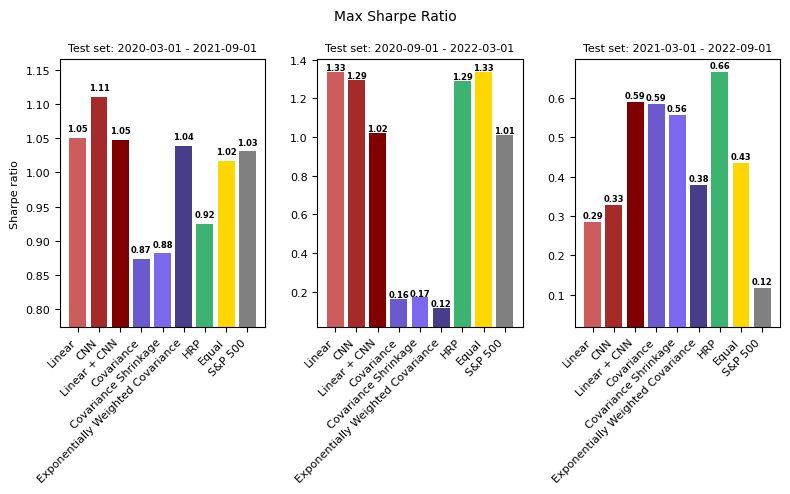

In [14]:
colours = ['indianred', 'brown', 'maroon', 'slateblue', 'mediumslateblue', 'darkslateblue', 'mediumseagreen', 'gold', 'gray']

fig, ax = plt.subplots(1, 3, figsize=(8, 5))
i=0
for date in results_sharpe.index:

    # Calculate test period
    test_start = datetime.strptime(date, '%Y-%m-%d') + relativedelta(years=3)
    test_end = test_start + relativedelta(years=1, months=6)

    # Plotting
    ax[i].bar(results_sharpe[results_sharpe.index==date].columns, np.squeeze(results_sharpe[results_sharpe.index==date].values), color = colours)
    plt.setp(ax[i].get_xticklabels(), rotation=45, ha='right', fontsize=8)
    plt.setp(ax[i].get_yticklabels(), fontsize=8)
    min_y = np.squeeze(results_sharpe[results_sharpe.index==date].values).min()-0.1
    ax[i].set_ylim(bottom = min_y)
    ax[i].set_title(f"Test set: {test_start.strftime('%Y-%m-%d')} - {test_end.strftime('%Y-%m-%d')}", fontsize = 8)

    # Add values to bars
    for j, v in enumerate(np.squeeze(results_sharpe[results_sharpe.index==date].values)):
        ax[i].text(j, v+0.01, str(round(v, 2)), color='black', fontweight='bold', fontsize=6, ha='center')

    i+=1

ax[0].set_ylabel('Sharpe ratio', fontsize=8)

fig.suptitle('Max Sharpe Ratio', fontsize=10)
fig.tight_layout();

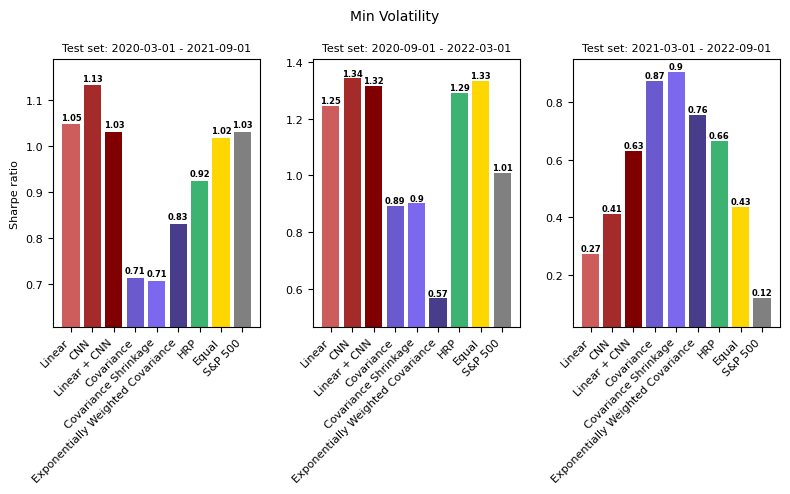

In [15]:
colours = ['indianred', 'brown', 'maroon', 'slateblue', 'mediumslateblue', 'darkslateblue', 'mediumseagreen', 'gold', 'gray']

fig, ax = plt.subplots(1, 3, figsize=(8, 5))
i=0
for date in results_volatility.index:

    # Calculate test period
    test_start = datetime.strptime(date, '%Y-%m-%d') + relativedelta(years=3)
    test_end = test_start + relativedelta(years=1, months=6)

    # Plotting
    ax[i].bar(results_volatility[results_volatility.index==date].columns, np.squeeze(results_volatility[results_volatility.index==date].values), color = colours)
    plt.setp(ax[i].get_xticklabels(), rotation=45, ha='right', fontsize=8)
    plt.setp(ax[i].get_yticklabels(), fontsize=8)
    min_y = np.squeeze(results_volatility[results_volatility.index==date].values).min()-0.1
    ax[i].set_ylim(bottom = min_y)
    ax[i].set_title(f"Test set: {test_start.strftime('%Y-%m-%d')} - {test_end.strftime('%Y-%m-%d')}", fontsize = 8)

    # Add values to bars
    for j, v in enumerate(np.squeeze(results_volatility[results_volatility.index==date].values)):
        ax[i].text(j, v+0.01, str(round(v, 2)), color='black', fontweight='bold', fontsize=6, ha='center')

    i+=1

ax[0].set_ylabel('Sharpe ratio', fontsize=8)

fig.suptitle('Min Volatility', fontsize=10)
fig.tight_layout();